In [0]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path):
   return glob.glob(path)

In [0]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [0]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'English', 'Scottish', 'Italian', 'Polish', 'Greek', 'Dutch', 'German', 'Japanese', 'Korean', 'Arabic', 'Portuguese', 'Russian', 'Vietnamese', 'Irish', 'Spanish', 'French', 'Chinese']
O'Neal


In [0]:
import torch
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
    return torch.tensor(letter_indexes).unsqueeze(1)

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes).unsqueeze(1)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [0]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor.to(device), input_line_tensor.to(device), target_line_tensor.to(device)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Gru(nn.Module):
    def __init__(self, input_dim, embed_dim, hid_dim, n_layers, dropout):
      super().__init__()
      self.input_dim = input_dim
      self.n_layers = n_layers
      self.hid_dim = hid_dim

      self.embedding = nn.Embedding(input_dim, embed_dim)

      self.rnn = nn.GRU(embed_dim+n_categories,
                        hid_dim, 
                        num_layers=n_layers, 
                        dropout = 0 if n_layers < 2 else dropout)
      
      self.fc = nn.Linear(hid_dim, input_dim)

    def forward(self, cat, inputs, hidden):

      #cat = [batch size, n_cats]
      #inputs = [batch size]

      emb = self.embedding(inputs)

      #emb = [batch size, emb dim]

      combined_input = torch.cat((cat, emb), 1)

      #combined_input = [batch size, n_cats + emb dim]

      combined_input=combined_input.unsqueeze(1)

      #combined_input = [batch size, 1, n_cats + emb dim]

      output, hidden = self.rnn(combined_input, hidden)

      #output = [batch size, 1, hid dim * num directions dim]
      #hidden = [n layers * num directions, batch size, hid dim]

      output = self.fc(output)

      #output = [batch size, 1, input dim]

      output = output.view(-1, self.input_dim)

      #output = [batch size*1, input_dim] == [1, input dim]

      return F.log_softmax(output, dim=1), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())

        return weight.new_zeros(self.n_layers, bsz, self.hid_dim)

In [0]:
embed_dim=50
hid_dim=128
n_layers =1
dropout = 0.1

model = Gru(n_letters, embed_dim, hid_dim, n_layers, dropout)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 86,593 trainable parameters


In [0]:
import torch.optim as optim

criterion = nn.NLLLoss()

In [0]:
model=model.to(device)
criterion=criterion.to(device)

In [0]:
learning_rate = 0.0003
optimizer = optim.Adam(model.parameters(), learning_rate)

In [0]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor.to(device), input_line_tensor.to(device), target_line_tensor.to(device)

In [0]:

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = model.init_hidden(1)
    hidden = hidden.to(device)

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)


In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [18]:

n_iters = 400000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 29s (5000 1%) 2.3057
0m 58s (10000 2%) 2.7438
1m 27s (15000 3%) 1.3473
1m 57s (20000 5%) 1.9445
2m 26s (25000 6%) 2.1666
2m 55s (30000 7%) 1.8209
3m 25s (35000 8%) 1.4389
3m 54s (40000 10%) 1.0307
4m 25s (45000 11%) 0.7397
4m 55s (50000 12%) 1.0539
5m 25s (55000 13%) 0.6305
5m 55s (60000 15%) 0.6090
6m 24s (65000 16%) 2.0908
6m 54s (70000 17%) 0.4279
7m 24s (75000 18%) 0.4347
7m 54s (80000 20%) 1.2629
8m 24s (85000 21%) 1.5171
8m 54s (90000 22%) 0.5225
9m 24s (95000 23%) 1.7410
9m 55s (100000 25%) 2.5282
10m 26s (105000 26%) 0.3434
10m 56s (110000 27%) 0.5114
11m 25s (115000 28%) 0.5101
11m 55s (120000 30%) 1.0082
12m 25s (125000 31%) 1.1695
12m 55s (130000 32%) 0.3047
13m 25s (135000 33%) 0.9919
13m 54s (140000 35%) 0.4813
14m 24s (145000 36%) 1.2289
14m 54s (150000 37%) 1.3477
15m 24s (155000 38%) 0.7123
15m 54s (160000 40%) 0.5899
16m 24s (165000 41%) 1.0183
16m 54s (170000 42%) 0.7102
17m 25s (175000 43%) 1.7910
17m 55s (180000 45%) 0.8850
18m 24s (185000 46%) 0.6262
18m 54s (19

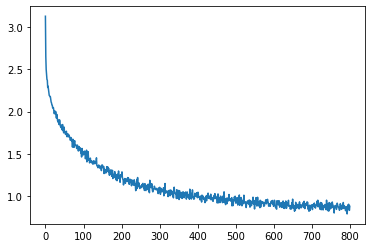

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.init_hidden(1)

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [42]:
sample('Italian',"E")

'Eliora'

In [40]:
sample('Italian','Rimin')

'Riminomano'

In [0]:
all_categories

['Czech',
 'English',
 'Scottish',
 'Italian',
 'Polish',
 'Greek',
 'Dutch',
 'German',
 'Japanese',
 'Korean',
 'Arabic',
 'Portuguese',
 'Russian',
 'Vietnamese',
 'Irish',
 'Spanish',
 'French',
 'Chinese']